In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('jamb_exam_results.csv')

In [4]:
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
string_columns = list(df.dtypes[df.dtypes == object].index)

for c in string_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [7]:
del df['student_id']

In [8]:
df.fillna(0).isna().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train['jamb_score'].values
y_val = df_val['jamb_score'].values
y_test = df_test['jamb_score'].values

In [12]:
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text


In [14]:
dv = DictVectorizer(sparse=False)

In [15]:
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

Question 1

In [16]:
from sklearn.tree import DecisionTreeRegressor

In [17]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [18]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))


|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



Question 2

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [20]:
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val,y_pred)
print(f"RMSE = {rmse}")

RMSE = 42.13724207871227


Question 3

In [22]:
scores = []

for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = round(root_mean_squared_error(y_val,y_pred),3)
    scores.append((n, rmse))

    print(f"n: {n}, rmse: {rmse:.3f}")


n: 10, rmse: 42.137
n: 20, rmse: 41.461
n: 30, rmse: 41.106
n: 40, rmse: 40.917
n: 50, rmse: 40.852
n: 60, rmse: 40.784
n: 70, rmse: 40.677
n: 80, rmse: 40.539
n: 90, rmse: 40.504
n: 100, rmse: 40.517
n: 110, rmse: 40.593
n: 120, rmse: 40.625
n: 130, rmse: 40.651
n: 140, rmse: 40.595
n: 150, rmse: 40.597
n: 160, rmse: 40.604
n: 170, rmse: 40.628
n: 180, rmse: 40.641
n: 190, rmse: 40.631
n: 200, rmse: 40.601


Question 4

In [23]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10,201,10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        rmse = round(root_mean_squared_error(y_val,y_pred),3)
        scores.append((n, d, rmse))

        #print(f"d: {d}, n: {n}, rmse: {rmse:.3f}")

In [24]:
columns = ['n_estimators','max_depth', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

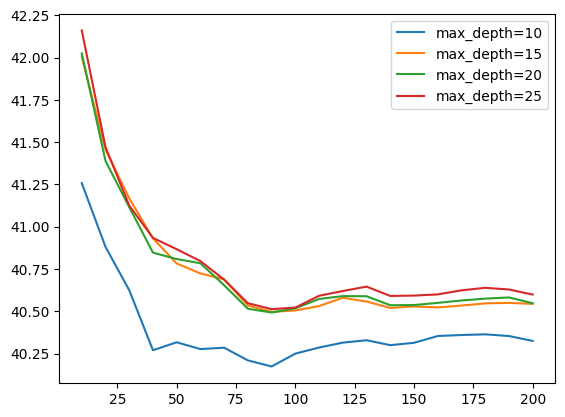

In [25]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]

    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

    plt.legend()

Question 5

In [26]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [27]:
y_pred = rf.predict(X_val)

In [28]:

feature_importance = rf.feature_importances_

In [29]:
feature_dict = dict(zip(dv.get_feature_names_out(), feature_importance))

In [30]:
features = ['study_hours_per_week',
'attendance_rate',
'distance_to_school',
'teacher_quality']

In [31]:
for feature in features:
    print(f"{feature}: {feature_dict.get(feature, 'Feature not found')}")

study_hours_per_week: 0.2483536119939654
attendance_rate: 0.14972902978467467
distance_to_school: 0.13648580486323686
teacher_quality: 0.08268222263880151


Question 6

In [32]:
!pip install xgboost


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import xgboost as xgb

In [34]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


In [35]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [38]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [41]:
s = output.stdout

In [44]:
print(s[:200])


[0]	train-rmse:42.69384	val-rmse:44.89114
[5]	train-rmse:34.57756	val-rmse:40.69096
[10]	train-rmse:31.63404	val-rmse:40.48319
[15]	train-rmse:29.41497	val-rmse:40.86107
[20]	train-rmse:27.49658	val-r


In [47]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [50]:
df_score = parse_xgb_output(output)

In [ ]:
scores = {}

In [54]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [55]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)


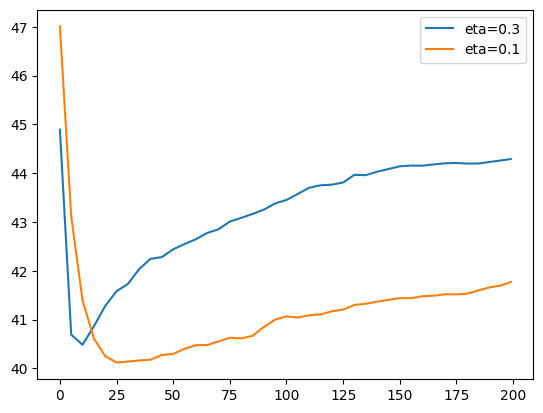

In [61]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.legend()